# Binary approach with dimensionality reduction

In [1]:
# Libraries
using DataFrames;
using CSV;
using Random;
using Statistics;
using ScikitLearn;
using Flux.Losses;
using Flux;
using Plots;
using StatsPlots;
using Printf;

@sk_import impute: KNNImputer; # Imputation of missing values.
@sk_import svm: SVC;
@sk_import decomposition: PCA;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;
@sk_import feature_selection: SelectKBest; # Feature Selection
@sk_import feature_selection: f_classif; # Used with SelectKBest

include("utils/fluxANNs.jl"); # for ANN training with Flux
include("utils/evaluation.jl"); # for confusion matrix calculatestimatorsion and cross validation set partitioning
include("utils/preprocessing.jl"); # for normalization, one-hot encoding, holdout division
include("utils/training.jl"); # for crossvalidation methodology
include("utils/visualizations.jl"); # for plots

# Set seed
Random.seed!(10);

[ Info: Running `conda install -y -c anaconda conda` in root environment


Channels:
 - anaconda
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/marcos/.julia/conda/3/x86_64

  added / updated specs:
    - conda


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.8.30~ --> anaconda/linux-64::certifi-2024.8.30-py312h06a4308_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


[ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<13.0'` in root environment


Channels:
 - conda-forge
 - anaconda
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/marcos/.julia/conda/3/x86_64

  added / updated specs:
    - libstdcxx-ng[version='>=3.4,<13.0']


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            anaconda/linux-64::certifi-2024.8.30-~ --> conda-forge/noarch::certifi-2024.8.30-pyhd8ed1ab_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# Hold-out partition

In [2]:
# loading the dataset
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');

# fate: 0 = recovery, 1 = death at home, 2 = death at the hospital
support2[:, "fate"] = support2[:,"death"] + support2[:,"hospdead"];
target_cols = ["death", "hospdead", "fate"];

trainIndex, testIndex = holdOut(nrow(support2), 0.2);

trainInputs = Array(support2[trainIndex, Not(target_cols)]);
testInputs = Array(support2[testIndex, Not(target_cols)]);

trainTargets = Array(support2[trainIndex, "death"]);
testTargets = Array(support2[testIndex, "death"]);

# Kfold
kFoldIndices = crossvalidation(trainTargets, 5);

# Imputation

In [3]:
imputer = KNNImputer(n_neighbors = 5);

trainInputs[:,1:32] = fit_transform!(imputer, trainInputs[:,1:32]);
testInputs[:,1:32] = imputer.transform(testInputs[:,1:32]);

# Visualizations

In [10]:
meanTrain, stdTrain = calculateZeroMeanNormalizationParameters(trainInputs[:,1:32]);
numInputs = normalizeZeroMean!(trainInputs[:,1:32], (meanTrain, stdTrain));

plot_correlations(numInputs);
savefig("plots/correlations.png");

# Train PCA on training dataset.
pca = PCA(2);
pcaInputs = fit_transform!(pca, numInputs);

# Draw results
draw_results(pcaInputs, trainTargets; colors=[:green,:red], target_names=["Survived", "Died"]);
savefig("plots/pca.png");

- ANN

In [4]:
ANNparams = [Dict("topology" => [2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [2, 2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4, 4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8, 8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16, 16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:ANN, ANNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices; reduceDimensions=true);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training ANN models:
Configuration 1: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [2], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 2, σ)   # 22 parameters
│   summary(x) = "10×5202 adjoint(::Matrix{Float64}) with eltype Float64"
└ @ Flux ~/.julia/packages/Flux/hiqg1/src/layers/stateless.jl:60


Accuracy:0.873416881326332 (87.34%), stdDev:0.005120544704601835 (0.51%)
F1-Score:0.9041668359990285 (90.42%), stdDev:0.0033668697275526334 (0.34%)

Configuration 2: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [4], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.873320129279825 (87.33%), stdDev:0.006564360670351429 (0.66%)
F1-Score:0.9041973619522736 (90.42%), stdDev:0.0042325322570128925 (0.42%)

Configuration 3: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [8], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8728634486257281 (87.29%), stdDev:0.006535735506352692 (0.65%)
F1-Score:0.903877594122676 (90.39%), stdDev:0.004362561210048207 (0.44%)

Configuration 4: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [16], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8732230421936181 (87.32%), stdDev:0.00560671479935

- SVM

In [5]:
SVMparams = [Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 1)]

models = [(:SVM, SVMparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices; reduceDimensions=true);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training SVM models:
Configuration 1: Dict{String, Any}("C" => 0.1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8667325912161559 (86.67%), stdDev:0.00921074610941897 (0.92%)
F1-Score:0.859347099809287 (85.93%), stdDev:0.05682470000058078 (5.68%)

Configuration 2: Dict{String, Any}("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8677009704922323 (86.77%), stdDev:0.008513523763343082 (0.85%)
F1-Score:0.859621042141321 (85.96%), stdDev:0.05802406972489269 (5.80%)

Configuration 3: Dict{String, Any}("C" => 0.1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8714378047358879 (87.14%), stdDev:0.004782239415350677 (0.48%)
F1-Score:0.8651940371830156 (86.52%), stdDev:0.0519361753753832 (5.19%)

Configuration 4: Dict{String, Any}("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8778027686300971 (87.78%), stdDev:0.0053148635498719435 (0.53%)
F1-Score:0.8720369451170311 (87.20%), stdDev:0.0491095494

- DecisionTree

In [6]:
DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16),
                Dict("maxDepth" => 32), Dict("maxDepth" => 64), Dict("maxDepth" => 128)]

models = [(:DTree, DTreeParams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices; reduceDimensions=true);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training DTree models:
Configuration 1: Dict("maxDepth" => 4)
Accuracy:0.8870752664856216 (88.71%), stdDev:0.003898496394635204 (0.39%)
F1-Score:0.8851105148402878 (88.51%), stdDev:0.034749381284964555 (3.47%)

Configuration 2: Dict("maxDepth" => 8)
Accuracy:0.8845819045392191 (88.46%), stdDev:0.0036037883699533194 (0.36%)
F1-Score:0.879656954481885 (87.97%), stdDev:0.04523540199374454 (4.52%)

Configuration 3: Dict("maxDepth" => 16)
Accuracy:0.858289585476798 (85.83%), stdDev:0.01129636499514417 (1.13%)
F1-Score:0.8512554150628467 (85.13%), stdDev:0.06111273140926431 (6.11%)

Configuration 4: Dict("maxDepth" => 32)
Accuracy:0.8517854477988143 (85.18%), stdDev:0.006986882938653191 (0.70%)
F1-Score:0.8414994418545101 (84.15%), stdDev:0.07036619186454351 (7.04%)

Configuration 5: Dict("maxDepth" => 64)
Accuracy:0.8517854477988143 (85.18%), stdDev:0.006986882938653191 (0.70%)
F1-Score:0.8414994418545101 (84.15%), stdDev:0.07036619186454351 (7.04%)

Configuration 6: Dict("maxDepth" => 128

- KNN

In [7]:
KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12),
            Dict("k" => 24), Dict("k" => 48), Dict("k" => 96)]

models = [(:KNN, KNNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices; reduceDimensions=true);
println("Best model is ", modelType, " with hyperparameters:");

println(params);


Training KNN models:
Configuration 1: Dict("k" => 3)
Accuracy:0.8512321012046857 (85.12%), stdDev:0.006195018143799913 (0.62%)
F1-Score:0.8426534914953482 (84.27%), stdDev:0.06523032291306964 (6.52%)

Configuration 2: Dict("k" => 6)
Accuracy:0.8627188454408914 (86.27%), stdDev:0.003860727943349614 (0.39%)
F1-Score:0.8582969709610706 (85.83%), stdDev:0.04989191322528688 (4.99%)

Configuration 3: Dict("k" => 12)
Accuracy:0.8679769261690465 (86.80%), stdDev:0.006170164761432945 (0.62%)
F1-Score:0.8613977194684344 (86.14%), stdDev:0.05375789484316565 (5.38%)

Configuration 4: Dict("k" => 24)
Accuracy:0.8701919384267243 (87.02%), stdDev:0.0049463984508814835 (0.49%)
F1-Score:0.8645095238114765 (86.45%), stdDev:0.0506764005228833 (5.07%)

Configuration 5: Dict("k" => 48)
Accuracy:0.8681177290157492 (86.81%), stdDev:0.00796542662675591 (0.80%)
F1-Score:0.8623064999230264 (86.23%), stdDev:0.051438652577348976 (5.14%)

Configuration 6: Dict("k" => 96)
Accuracy:0.8659011838109167 (86.59%), stdD

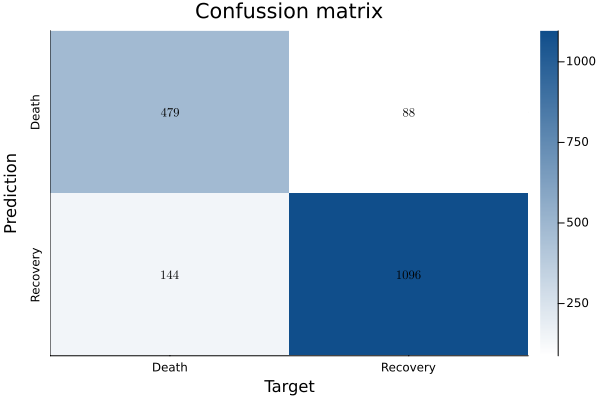

In [8]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end
train, val, test = prepareDataForFitting(train, test, valRatio; reduceDimensions=true)

classes = unique(trainTargets)
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes)
confMat = matAndMetrics[8]

class_map = Dict(0 => "Recovery", 1 => "Death")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)

- Ensemble

In [11]:
@sk_import ensemble:StackingClassifier

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
estimators = [:KNN, :DTree, :SVM]
params = []
DTreeParams = Dict("maxDepth" => 4)
KNNparams = Dict("k" => 24)
SVMparams = Dict("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)

params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

printCrossValOutput(trainClassEnsemble(estimators, params, (trainInputs, trainTargets),
                   crossvalidation(trainTargets, 5); reduceDimensions=true));

Accuracy:0.8854118748479298

 (88.54%), stdDev:0.010389035159210728 (1.04%)
F1-Score:0.8974457309819602 (89.74%), stdDev:0.024762620661573583 (2.48%)



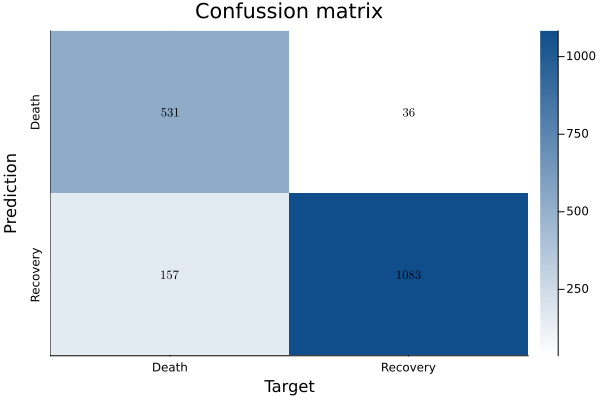

In [12]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# standardization is applied
trainNorm, _, testNorm = prepareDataForFitting(train, test; reduceDimensions=true)
ensemble = fitEnsemble(trainNorm, estimators, params)

classes = unique(trainTargets)
matAndMetrics = confusionMatrix(predict(ensemble, testNorm[1]), testNorm[2]; weighted=true)
confMat = matAndMetrics[8]

class_map = Dict(0 => "Recovery", 1 => "Death")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)